#  NLP - Categorize articles from the BBC news archive


In this notebook we will create a classification model for texts from the BBC news archive. These texts are categorized into 5 different types: sport, business, politics, tech and entertainment.

We will use Tensorflow for the text classification.

This notebook will have the following structure:
1. Load & explore the data
2. Preprocess the data
3. Define & compile the model
4. Train the model
5. Evaluate the model


## 1. Load and explore the data

Import libraries

In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from os import getcwd
%matplotlib inline
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

### Load the data
Download the data

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv


#Download a list of stopwords from https://github.com/Yoast/YoastSEO.js/blob/develop/src/config/stopwords.js
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]


--2021-09-09 15:36:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.196.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.04s   

2021-09-09 15:36:45 (120 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [ ]:
# each article is onle long sentence and each article has one label.
# add the articles as sentences to a list
# add the labels to the labels list
sentences = []
labels = []
with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for row in reader:
      labels.append(row[0])
      sentence = row[1]
      for word in stopwords:
        token = " " + word + " "
        sentence = sentence.replace(token, " ")
        sentence = sentence.replace("  ", " ")
      sentences.append(sentence) 
      
print(len(labels))  # we have 2225 labeled articles
print(len(sentences))
print(sentences[0])
print(labels[0])

2225
2225
tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us s tivo uk s sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take off europe lack high-definition programming. not can people forward wind adverts can also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cab

## 2. Preprocess the data

In [ ]:
# HYPERPARAMETERS 

vocab_size = 10000   # we take the max vocab_size words used for our tokenization. the rest will get the oov_tok  
embedding_dim = 64   # dimension of our vector to embed the words
max_length = 120     # max length of a sentence
trunc_type = 'post'  # we truncated at the end
padding_type = 'post' # we have the letters in the beginning
oov_tok = "<OOV>"
training_portion = .8  # we use 80% of the data for training 

Split the dataset into a train and test set

In [ ]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


Tokenize the sentences.

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok) # create the tokenizer
tokenizer.fit_on_texts(train_sentences) # encode using the words the sentences we have 
word_index = tokenizer.word_index  # create key value pairs with tokens and words

train_sequences = tokenizer.texts_to_sequences(train_sentences)  # applies the tokens to each sentence.
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length) # pad the tokenized sentences

print(train_sentences[0]) # original sentence
print(train_sequences[0]) # tokenized sentence
print(train_padded[0]) # padded tokenized sentence
print(len(train_sequences[0])) # in total 200 tokens
print(len(train_padded[0]))   # only 120 tokens


tv future hands viewers home theatre systems plasma high-definition tvs digital video recorders moving living room way people watch tv will radically different five years time. according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend programmes content will delivered viewers via home networks cable satellite telecoms companies broadband service providers front rooms portable devices. one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes like us s tivo uk s sky+ system allow people record store play pause forward wind tv programmes want. essentially technology allows much personalised tv. also built-in high-definition tv sets big business japan us slower take off europe lack high-definition programming. not can people forward wind adverts can also forget abiding network channel schedules putting together a-la-carte entertainment. us networks cable satelli

Tokenize the validation sentences

In [ ]:
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)

445
(445, 120)


Tokenize the labels

In [ ]:
# now we token each label 

label_tokenizer = Tokenizer() # create the tokenizer
label_tokenizer.fit_on_texts(labels) # encodes the labels we have (5 labels so 5 tokens)
label_word_index = label_tokenizer.word_index # create key value pairs with tokens and words
label_seq = label_tokenizer.texts_to_sequences(labels) # applies the tokens to each label.

print(label_seq)
print(label_word_index)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))


[[4], [2], [1], [1], [5], [3], [3], [1], [1], [5], [5], [2], [2], [3], [1], [2], [3], [1], [2], [4], [4], [4], [1], [1], [4], [1], [5], [4], [3], [5], [3], [4], [5], [5], [2], [3], [4], [5], [3], [2], [3], [1], [2], [1], [4], [5], [3], [3], [3], [2], [1], [3], [2], [2], [1], [3], [2], [1], [1], [2], [2], [1], [2], [1], [2], [4], [2], [5], [4], [2], [3], [2], [3], [1], [2], [4], [2], [1], [1], [2], [2], [1], [3], [2], [5], [3], [3], [2], [5], [2], [1], [1], [3], [1], [3], [1], [2], [1], [2], [5], [5], [1], [2], [3], [3], [4], [1], [5], [1], [4], [2], [5], [1], [5], [1], [5], [5], [3], [1], [1], [5], [3], [2], [4], [2], [2], [4], [1], [3], [1], [4], [5], [1], [2], [2], [4], [5], [4], [1], [2], [2], [2], [4], [1], [4], [2], [1], [5], [1], [4], [1], [4], [3], [2], [4], [5], [1], [2], [3], [2], [5], [3], [3], [5], [3], [2], [5], [3], [3], [5], [3], [1], [2], [3], [3], [2], [5], [1], [2], [2], [1], [4], [1], [4], [4], [1], [2], [1], [3], [5], [3], [2], [3], [2], [4], [3], [5], [3], [4], [2],

## 3. Define & compile the model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
#tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 120, 64)           640000    
_________________________________________________________________
global_average_pooling1d_3 ( (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 24)                1560      
_________________________________________________________________
dense_22 (Dense)             (None, 6)                 150       
Total params: 641,710
Trainable params: 641,710
Non-trainable params: 0
_________________________________________________________________


## 4. Train the model

In [ ]:
num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/30
56/56 - 1s - loss: 1.7386 - accuracy: 0.6039 - val_loss: 1.6561 - val_accuracy: 0.7236
Epoch 2/30
56/56 - 0s - loss: 1.4713 - accuracy: 0.8185 - val_loss: 1.2827 - val_accuracy: 0.8584
Epoch 3/30
56/56 - 0s - loss: 0.9879 - accuracy: 0.9365 - val_loss: 0.8309 - val_accuracy: 0.9236
Epoch 4/30
56/56 - 0s - loss: 0.5583 - accuracy: 0.9792 - val_loss: 0.5167 - val_accuracy: 0.9461
Epoch 5/30
56/56 - 0s - loss: 0.2945 - accuracy: 0.9888 - val_loss: 0.3484 - val_accuracy: 0.9416
Epoch 6/30
56/56 - 0s - loss: 0.1629 - accuracy: 0.9910 - val_loss: 0.2635 - val_accuracy: 0.9528
Epoch 7/30
56/56 - 0s - loss: 0.0980 - accuracy: 0.9955 - val_loss: 0.2170 - val_accuracy: 0.9528
Epoch 8/30
56/56 - 0s - loss: 0.0622 - accuracy: 0.9994 - val_loss: 0.1891 - val_accuracy: 0.9506
Epoch 9/30
56/56 - 0s - loss: 0.0419 - accuracy: 0.9994 - val_loss: 0.1710 - val_accuracy: 0.9551
Epoch 10/30
56/56 - 0s - loss: 0.0296 - accuracy: 1.0000 - val_loss: 0.1597 - val_accuracy: 0.9551
Epoch 11/30
56/56 -

## 5. Evaluate the model

<Figure size 432x288 with 0 Axes>

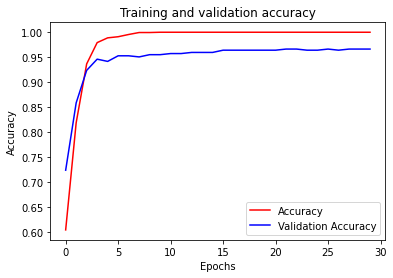

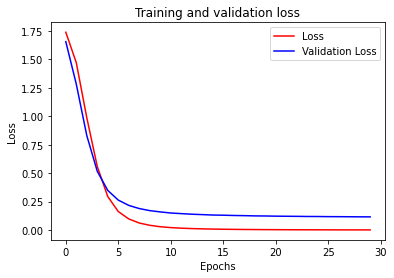

<Figure size 432x288 with 0 Axes>

In [ ]:


#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

Using tensorflow projector we can visualise the clustering of the vectorized words. We see in the screenshot below that the clustering of the words looks quite good.

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])
    

In [ ]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [ ]:
# create a vectors file
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')


# https://projector.tensorflow.org/

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

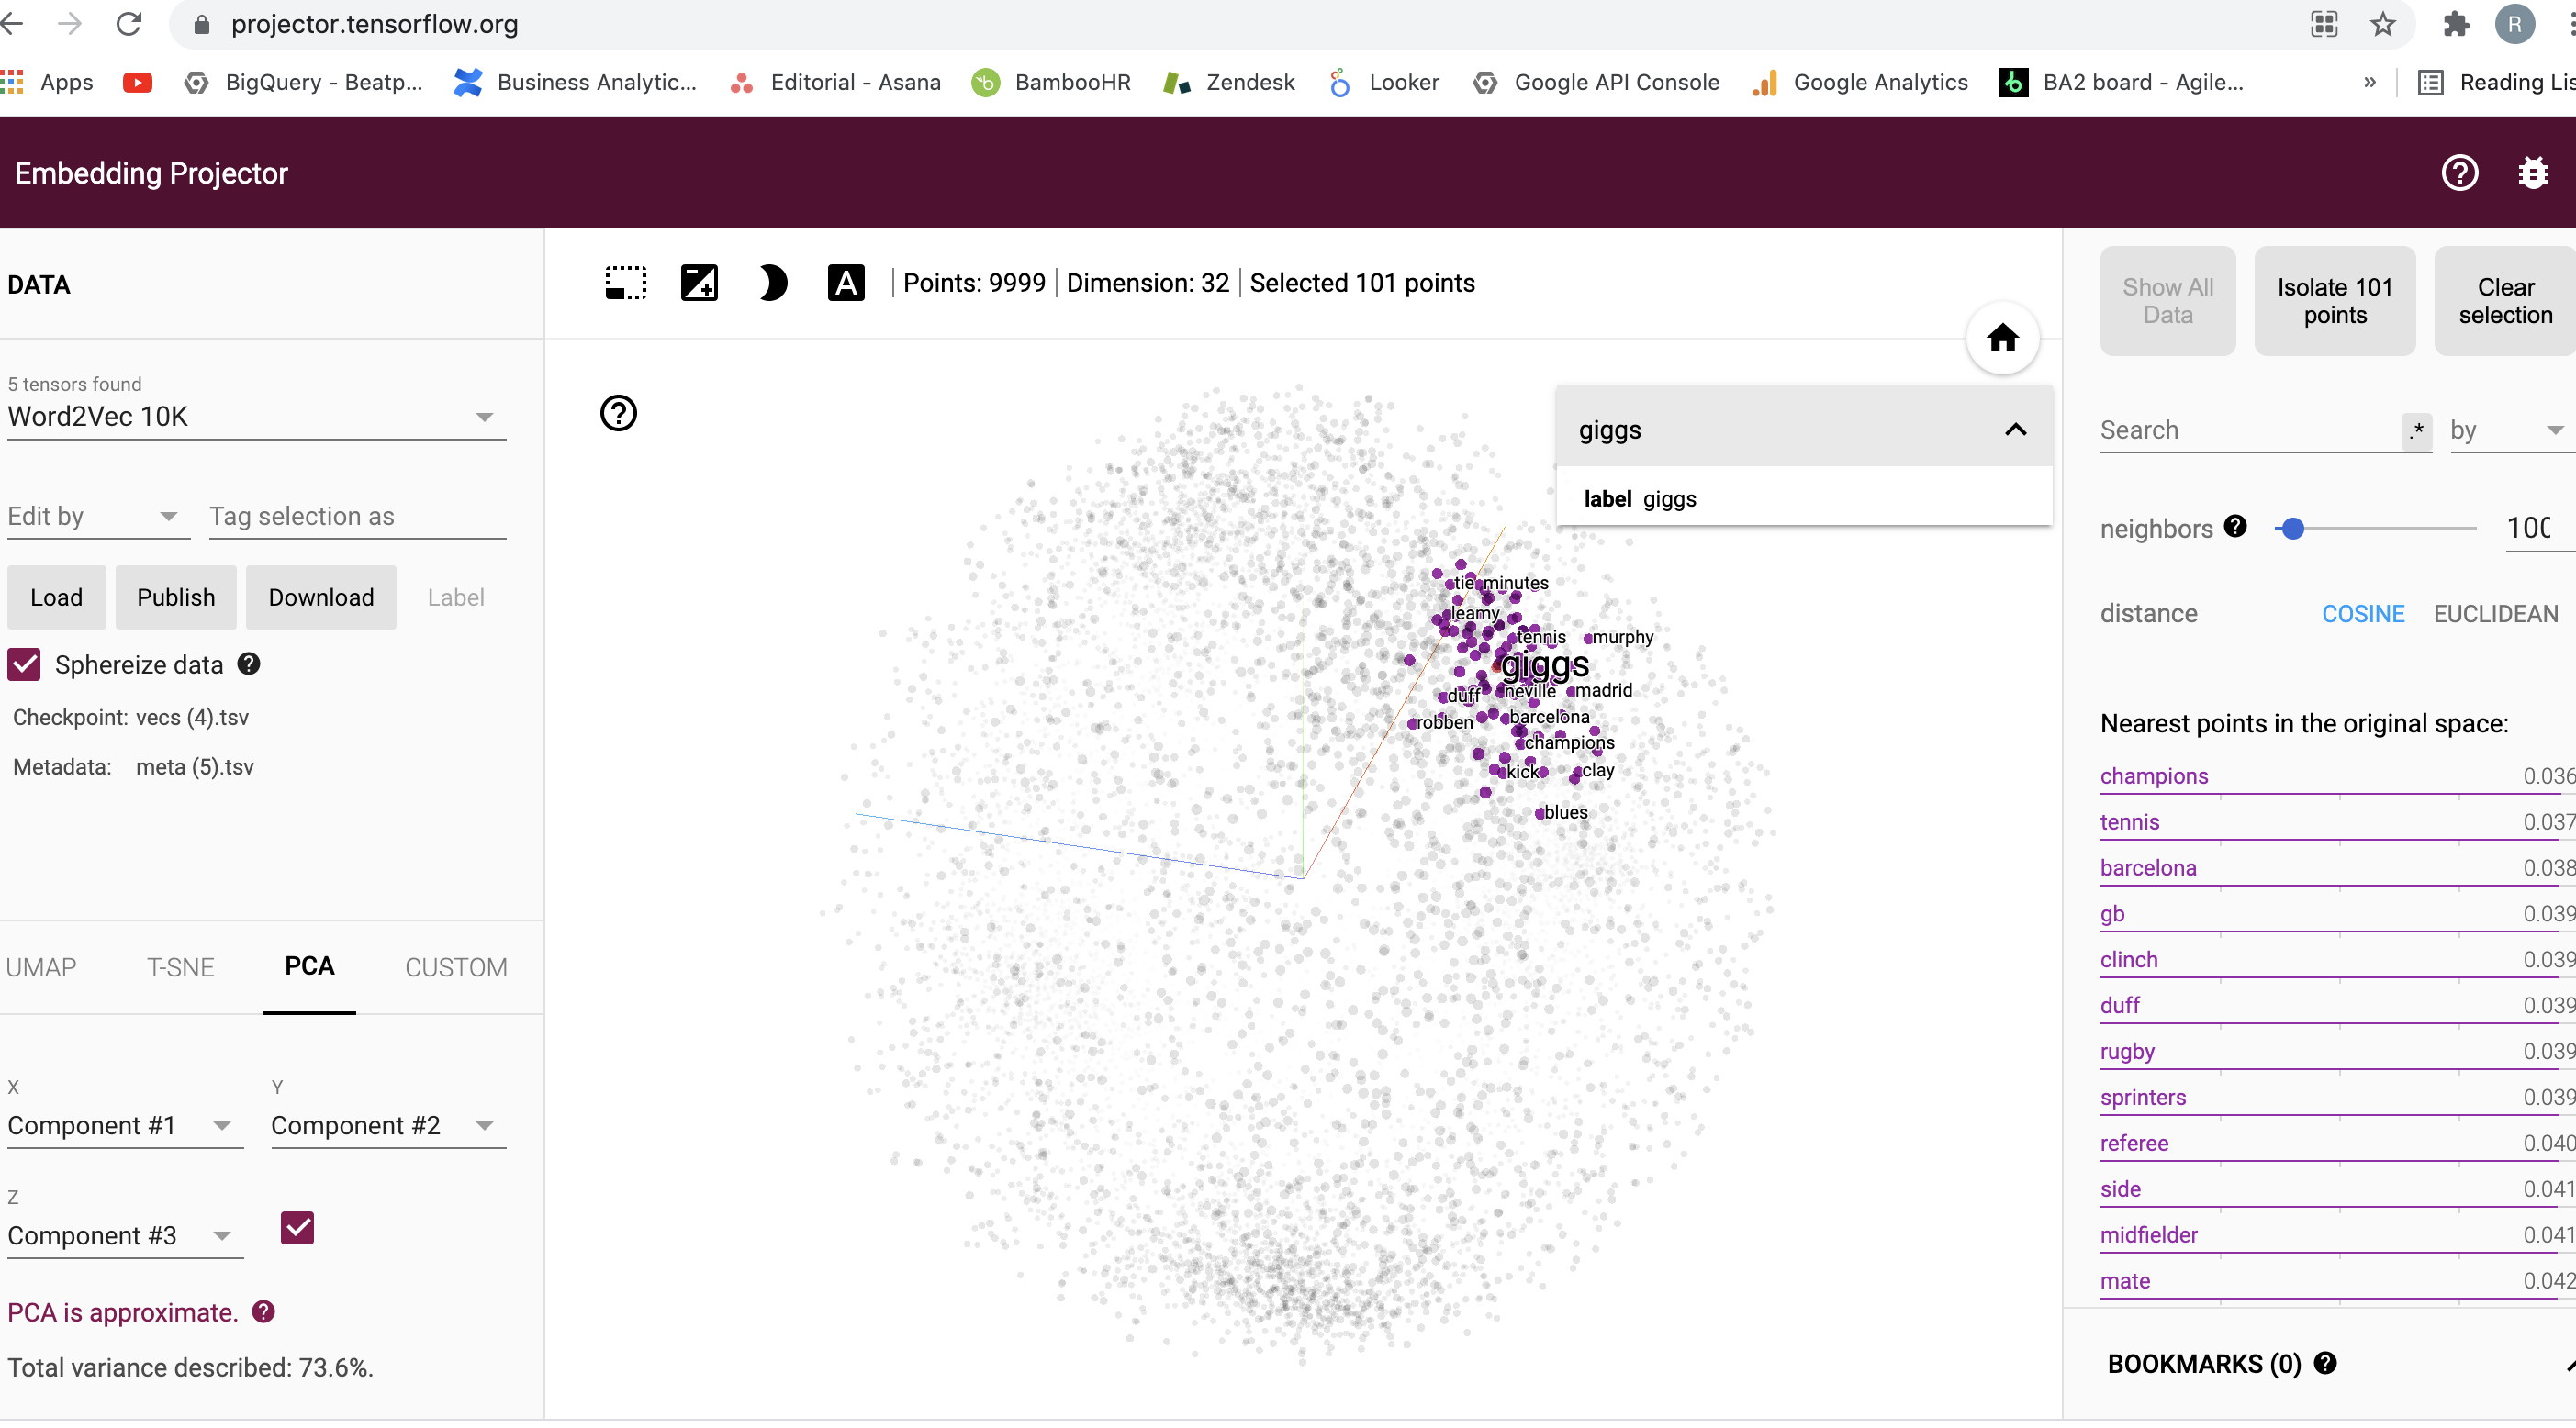